# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

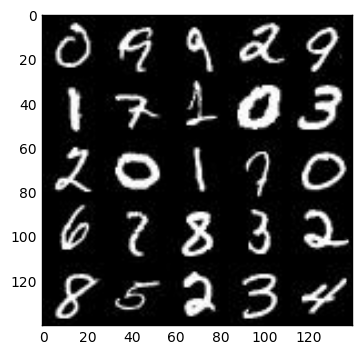

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

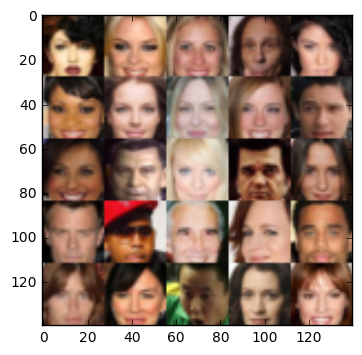

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real=tf.placeholder(tf.float32,[None,image_height,image_width,image_channels])
    imag=tf.placeholder(tf.float32,[None,z_dim])
    lr=tf.placeholder(tf.float32)
    return real, imag, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2,dropout=0.75):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    pkeep=tf.constant(dropout,dtype=tf.float32)
    
    with tf.variable_scope('discriminator',reuse=reuse):
        n_channels=images.get_shape().as_list()[3]
        #First convolutonal layer
        conv1=tf.layers.conv2d(images,16,[5,5],[2,2],padding='same') #None,14,14,16
        conv1=tf.layers.batch_normalization(conv1,training=True)
        conv1=tf.maximum(alpha*conv1,conv1)
        
        #Second convolutoinal layer
        conv2=tf.layers.conv2d(conv1,32,[5,5],[2,2],padding='same') #None,7,7,32
        conv2=tf.layers.batch_normalization(conv2,training=True)
        conv2=tf.maximum(alpha*conv2,conv2)
                
        #Third convolutional layer
        conv3=tf.layers.conv2d(conv2,64,[5,5],[2,2],padding='same') #None,4,4,64
        conv3=tf.layers.batch_normalization(conv3,training=True)
        conv3=tf.maximum(alpha*conv3,conv3)
        
        #Average the width and height channels before flattening
        flat=tf.reduce_mean(conv3,axis=1) #None,4,64
        flat=tf.reduce_mean(flat,axis=1) #None,64
        
        #fc6=tf.layers.dense(flat,16)
        
        logits=tf.layers.dense(flat,1)
        output=tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
from tensorflow.python.layers import utils

In [8]:
utils.deconv_output_length(input_length=3,padding='valid',filter_size=3,stride=2) #calculate the output of deconv layer

7

In [9]:
def generator(z, out_channel_dim, is_train=True,alpha=0.2,dropout=0.75):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator',reuse=not is_train):
        if is_train:
            pkeep=tf.constant(dropout,dtype=tf.float32)
        else:
            pkeep=tf.constant(1,dtype=tf.float32)


        #first dense layer, reshaped to 4D
        x=tf.layers.dense(z,3*3*128)
        x=tf.reshape(x,tf.constant([-1,3,3,128],dtype=tf.int32)) #3x3
        x=tf.layers.batch_normalization(x,training=is_train)
        x=tf.maximum(alpha*x,x)
        
#         convT1=tf.layers.conv2d_transpose(x,filters=64,kernel_size=1,padding='valid',strides=1) #3x3
#         convT1=tf.layers.batch_normalization(convT1,training=is_train)
#         convT1=tf.maximum(alpha*convT1,convT1)
        
        convT2=tf.layers.conv2d_transpose(x,filters=64,kernel_size=3,padding='valid',strides=2,
                                          kernel_initializer= tf.truncated_normal_initializer(stddev=1e-1)) #7x7
        convT2=tf.layers.batch_normalization(convT2,training=is_train)
        convT2=tf.maximum(alpha*convT2,convT2)
        convT2=tf.nn.dropout(convT2,keep_prob=pkeep)
        
        convT3=tf.layers.conv2d_transpose(convT2,filters=32,kernel_size=5,padding='same',strides=2
                                          ,kernel_initializer= tf.truncated_normal_initializer(stddev=1e-1)) #14x14
        convT3=tf.layers.batch_normalization(convT3,training=is_train)
        convT3=tf.maximum(alpha*convT3,convT3)
        convT3=tf.nn.dropout(convT3,keep_prob=pkeep)
        
        logits=tf.layers.conv2d_transpose(convT3,filters=out_channel_dim,kernel_size=5,padding='same',strides=2,
                                          kernel_initializer= tf.truncated_normal_initializer(stddev=1e-1)) #28x28
        out=tf.tanh(logits)
    # TODO: Implement Function
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim,dropout=0.75):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model=generator(input_z,out_channel_dim,is_train=True,dropout=dropout) #images
    d_out_real,d_logits_real=discriminator(input_real,reuse=False) #returns output,logits
    d_out_fake,d_logits_fake=discriminator(g_model,reuse=True)
    
    d_loss_real=tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,labels=0.9*tf.ones_like(d_logits_real))
    d_loss_fake=tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=tf.zeros_like(d_logits_fake))
    
    g_loss=tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,labels=0.9*tf.ones_like(d_logits_fake))
    
    d_loss=tf.reduce_mean(d_loss_real)+tf.reduce_mean(d_loss_fake)
    g_loss=tf.reduce_mean(g_loss)
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    all_vars=tf.trainable_variables()
    
    d_vars=[v for v in all_vars if v.name.startswith('discriminator')]
    g_vars=[v for v in all_vars if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_opt=tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_opt,g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,dropout=0.75, seed=0):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    n_channels= 3 if data_image_mode=='RGB' else 1
    
    inputs_real,inputs_imag,lr=model_inputs(28, 28, n_channels, z_dim)
    
    d_loss, g_loss=model_loss(inputs_real, inputs_imag, n_channels,dropout=dropout)
    
    d_opt,g_opt=model_opt(d_loss, g_loss, lr, beta1)
    
    count=0
    with tf.Session() as sess:
        tf.set_random_seed(seed)
        np.random.seed(seed)
        saver=tf.train.Saver()
        savename='./checkpoints/'+('celeba_' if data_image_mode=='RGB' else 'mnist_')+'generator.ckpt'
        sess.run(tf.global_variables_initializer())
        try:
            for epoch_i in range(epoch_count):
                for batch_images in get_batches(batch_size):
                    batch_images=2*batch_images
                    
                    count+=1
                    learn=learning_rate/(2**(epoch_i))
                    # TODO: Train Model

                    #generator
                    z_in=np.random.uniform(-1,1,size=(batch_size,z_dim)) #2*np.random.random(size=(batch_size,z_dim))-1
                    feed={inputs_real:batch_images,inputs_imag:z_in,lr:learn}
                    _=sess.run(d_opt,feed_dict=feed)
                    #_=sess.run(d_opt,feed_dict=feed)

                    #optimize generator twice
                    _=sess.run(g_opt,feed_dict=feed)
                    _=sess.run(g_opt,feed_dict=feed)

                    if count%100==0:
                        d_cost=sess.run(d_loss,feed_dict=feed)
                        g_cost=sess.run(g_loss,feed_dict=feed)
                        print('Epoch {}/{}, D loss= {:.3f}, G loss={:.3f}'.format(epoch_i+1,epoch_count,d_cost,g_cost))
                        if count%500==0:
                            show_generator_output(sess, 25, inputs_imag, n_channels, data_image_mode)

            saver.save(sess, savename)
            show_generator_output(sess, 25, inputs_imag, n_channels, data_image_mode)
            walk(sess,5,inputs_imag,n_channels,data_image_mode,n_interpolations=3)
        finally:
             saver.save(sess, savename)

In [14]:
def walk(session, n_points, imag,channels,data_image_mode,n_interpolations=8):
    """
    This function shows the quality of representation learnt by generator
    by 'going for a walk' in the representation space, similar to figure 4 in DCGAN paper
    Walking involves sampling two points a,b in the z space and finding points
    between a & b. All these points are fed into the generator and the outputs are visualized
    If there are sudden changes in the generator output between (a,b) it means the network is overfitting
    and memorizing the dataset.
    Tip: always call this function with n_points=n_interpolations+2 to visualize images in a square grid
    """
    cmap = None if data_image_mode == 'RGB' else 'gray'
    
    z_dim = imag.get_shape().as_list()[-1]
    example_z=[]
    for idx in range(n_points):
        a = np.random.uniform(-1, 0, size=[1, z_dim])
        b = np.random.uniform(0, 1, size=[1, z_dim])
        delta=(b-a)/(n_interpolations+1)
        example_z.append([a+i*delta for i in range(n_interpolations+2)])

    example_z=np.array(example_z).reshape(-1,z_dim)
    
    samples = session.run(
        generator(imag, channels, False),
        feed_dict={imag: example_z})
    
    print('Walking...')
    images_grid = helper.images_square_grid(samples, data_image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, D loss= 1.241, G loss=0.848
Epoch 1/2, D loss= 1.219, G loss=0.869
Epoch 1/2, D loss= 1.249, G loss=0.876
Epoch 1/2, D loss= 1.219, G loss=0.890
Epoch 1/2, D loss= 1.194, G loss=0.894


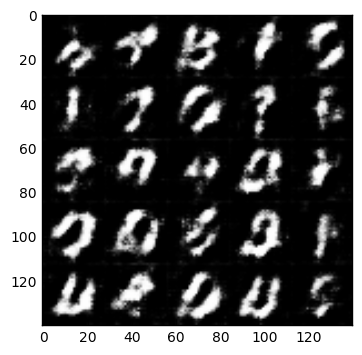

Epoch 1/2, D loss= 1.207, G loss=0.874
Epoch 1/2, D loss= 1.217, G loss=0.840
Epoch 1/2, D loss= 1.198, G loss=0.902
Epoch 1/2, D loss= 1.211, G loss=0.867
Epoch 1/2, D loss= 1.168, G loss=0.878


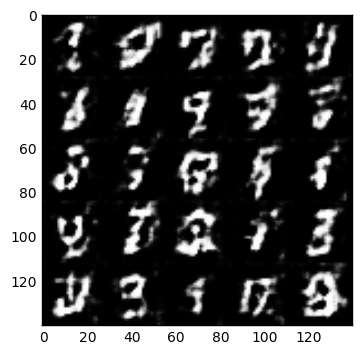

Epoch 1/2, D loss= 1.155, G loss=0.925
Epoch 1/2, D loss= 1.144, G loss=0.956
Epoch 1/2, D loss= 1.108, G loss=0.963
Epoch 1/2, D loss= 1.061, G loss=0.946
Epoch 1/2, D loss= 1.042, G loss=0.982


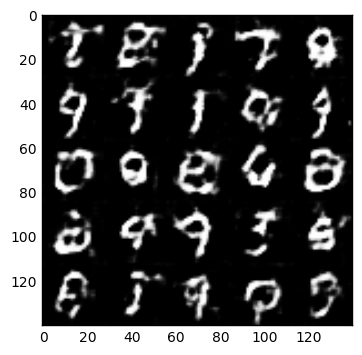

Epoch 1/2, D loss= 1.092, G loss=1.028
Epoch 1/2, D loss= 1.073, G loss=0.982
Epoch 1/2, D loss= 1.207, G loss=0.877
Epoch 2/2, D loss= 1.037, G loss=1.072
Epoch 2/2, D loss= 1.069, G loss=1.007


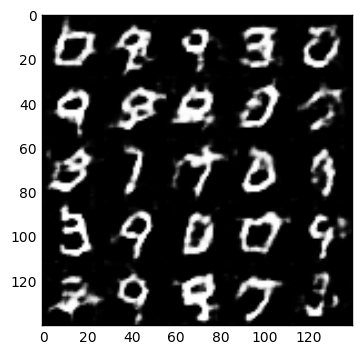

Epoch 2/2, D loss= 0.997, G loss=1.078
Epoch 2/2, D loss= 1.039, G loss=0.945
Epoch 2/2, D loss= 0.958, G loss=1.102
Epoch 2/2, D loss= 1.003, G loss=1.103
Epoch 2/2, D loss= 0.955, G loss=1.020


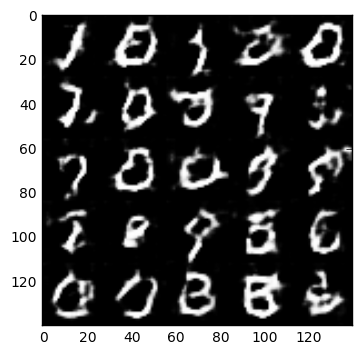

Epoch 2/2, D loss= 1.010, G loss=1.118
Epoch 2/2, D loss= 0.946, G loss=1.101
Epoch 2/2, D loss= 1.050, G loss=0.922
Epoch 2/2, D loss= 1.000, G loss=1.050
Epoch 2/2, D loss= 1.060, G loss=1.006


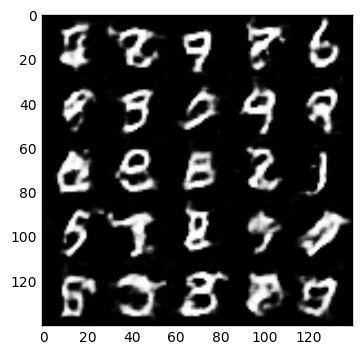

Epoch 2/2, D loss= 0.991, G loss=1.105
Epoch 2/2, D loss= 0.912, G loss=1.159
Epoch 2/2, D loss= 0.957, G loss=1.114
Epoch 2/2, D loss= 0.995, G loss=0.972
Epoch 2/2, D loss= 0.931, G loss=1.094


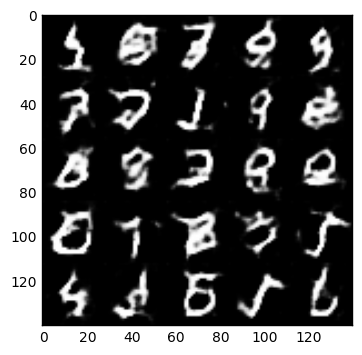

Epoch 2/2, D loss= 0.960, G loss=1.088
Epoch 2/2, D loss= 1.007, G loss=0.971


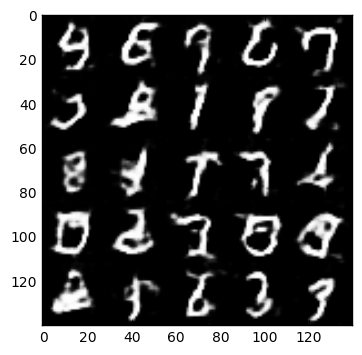

Walking...


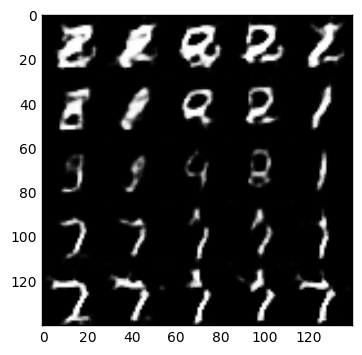

In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode,seed=10,dropout=0.75)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, D loss= 1.170, G loss=1.026
Epoch 1/1, D loss= 1.199, G loss=0.936
Epoch 1/1, D loss= 1.069, G loss=1.040
Epoch 1/1, D loss= 1.078, G loss=0.988
Epoch 1/1, D loss= 1.005, G loss=1.041


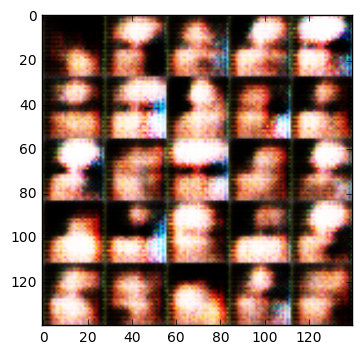

Epoch 1/1, D loss= 1.140, G loss=0.967
Epoch 1/1, D loss= 1.202, G loss=0.868
Epoch 1/1, D loss= 1.299, G loss=0.807
Epoch 1/1, D loss= 1.338, G loss=0.793
Epoch 1/1, D loss= 1.322, G loss=0.800


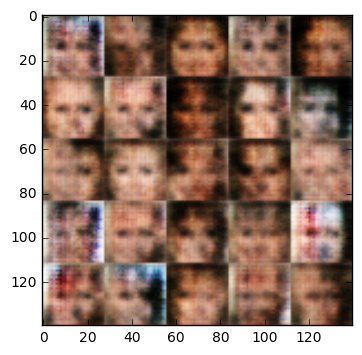

Epoch 1/1, D loss= 1.333, G loss=0.808
Epoch 1/1, D loss= 1.378, G loss=0.778
Epoch 1/1, D loss= 1.345, G loss=0.787
Epoch 1/1, D loss= 1.322, G loss=0.792
Epoch 1/1, D loss= 1.346, G loss=0.783


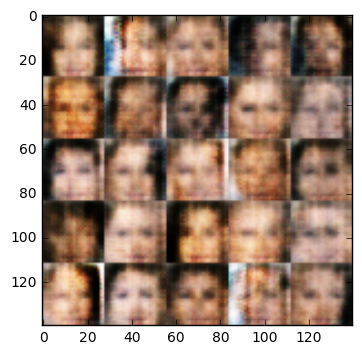

Epoch 1/1, D loss= 1.370, G loss=0.800
Epoch 1/1, D loss= 1.354, G loss=0.794
Epoch 1/1, D loss= 1.273, G loss=0.792
Epoch 1/1, D loss= 1.321, G loss=0.813
Epoch 1/1, D loss= 1.356, G loss=0.822


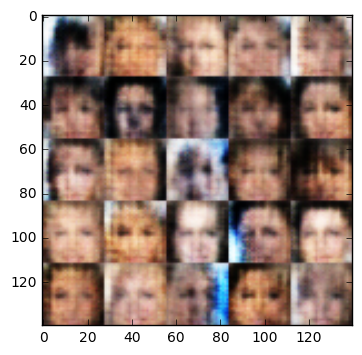

Epoch 1/1, D loss= 1.322, G loss=0.792
Epoch 1/1, D loss= 1.342, G loss=0.800
Epoch 1/1, D loss= 1.307, G loss=0.804
Epoch 1/1, D loss= 1.351, G loss=0.792
Epoch 1/1, D loss= 1.334, G loss=0.773


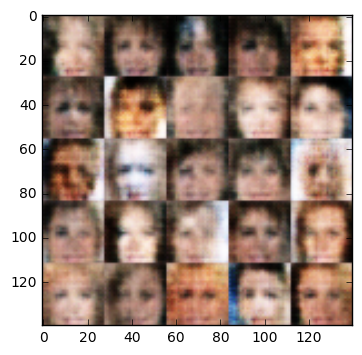

Epoch 1/1, D loss= 1.362, G loss=0.788
Epoch 1/1, D loss= 1.334, G loss=0.739
Epoch 1/1, D loss= 1.274, G loss=0.786
Epoch 1/1, D loss= 1.337, G loss=0.767
Epoch 1/1, D loss= 1.311, G loss=0.831


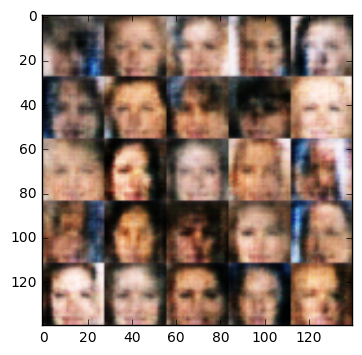

Epoch 1/1, D loss= 1.341, G loss=0.783
Epoch 1/1, D loss= 1.325, G loss=0.782
Epoch 1/1, D loss= 1.324, G loss=0.813
Epoch 1/1, D loss= 1.351, G loss=0.789
Epoch 1/1, D loss= 1.347, G loss=0.837


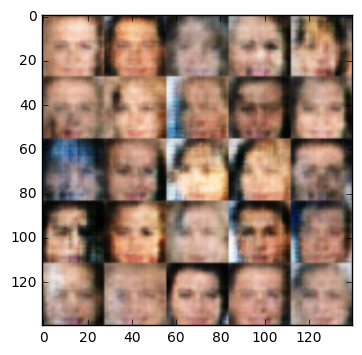

Epoch 1/1, D loss= 1.361, G loss=0.788
Epoch 1/1, D loss= 1.330, G loss=0.815
Epoch 1/1, D loss= 1.308, G loss=0.795
Epoch 1/1, D loss= 1.329, G loss=0.819
Epoch 1/1, D loss= 1.271, G loss=0.800


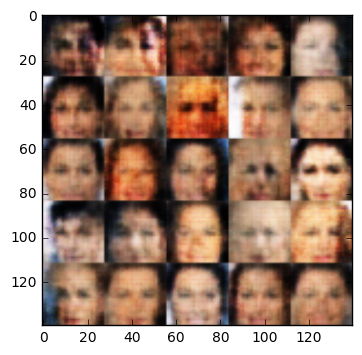

Epoch 1/1, D loss= 1.374, G loss=0.776
Epoch 1/1, D loss= 1.331, G loss=0.843
Epoch 1/1, D loss= 1.409, G loss=0.748
Epoch 1/1, D loss= 1.306, G loss=0.749
Epoch 1/1, D loss= 1.336, G loss=0.782


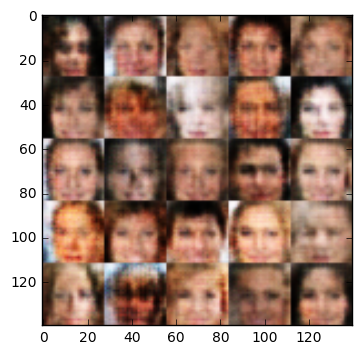

Epoch 1/1, D loss= 1.353, G loss=0.791
Epoch 1/1, D loss= 1.340, G loss=0.802
Epoch 1/1, D loss= 1.340, G loss=0.817
Epoch 1/1, D loss= 1.335, G loss=0.829
Epoch 1/1, D loss= 1.302, G loss=0.791


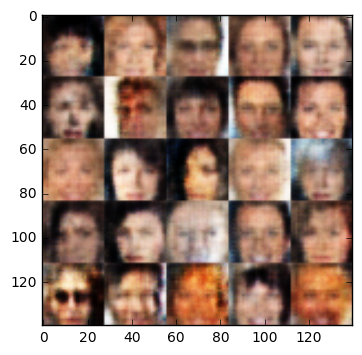

Epoch 1/1, D loss= 1.325, G loss=0.800
Epoch 1/1, D loss= 1.358, G loss=0.821
Epoch 1/1, D loss= 1.353, G loss=0.791
Epoch 1/1, D loss= 1.340, G loss=0.804
Epoch 1/1, D loss= 1.348, G loss=0.796


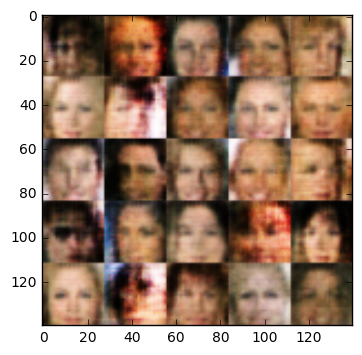

Epoch 1/1, D loss= 1.359, G loss=0.763
Epoch 1/1, D loss= 1.318, G loss=0.794
Epoch 1/1, D loss= 1.306, G loss=0.817
Epoch 1/1, D loss= 1.314, G loss=0.796
Epoch 1/1, D loss= 1.348, G loss=0.836


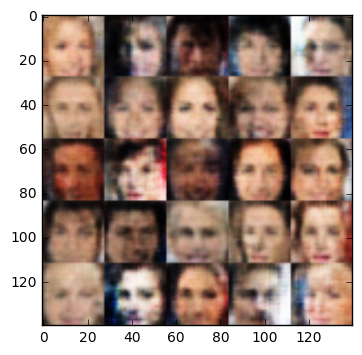

Epoch 1/1, D loss= 1.306, G loss=0.797
Epoch 1/1, D loss= 1.307, G loss=0.827
Epoch 1/1, D loss= 1.297, G loss=0.827


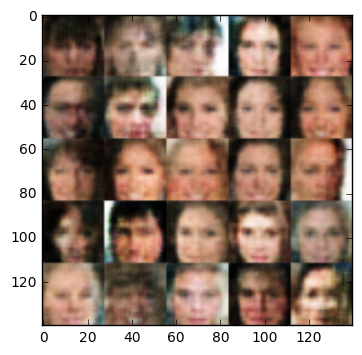

Walking...


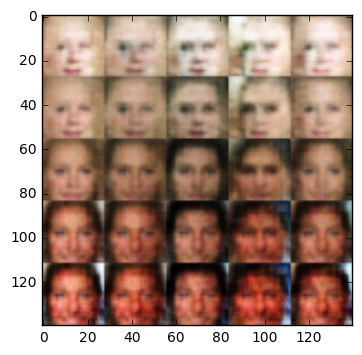

In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode,seed=5)

### The walk in the representation space (arranged in columns) shows that each intermediate step between the top and bottom face is also a realistic face and the faces change gradually during the walk. This suggests that the generator has learnt the probability distribution well and does not overfit the training data

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.